In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

Generating 8 plots with cleaned x-axis...


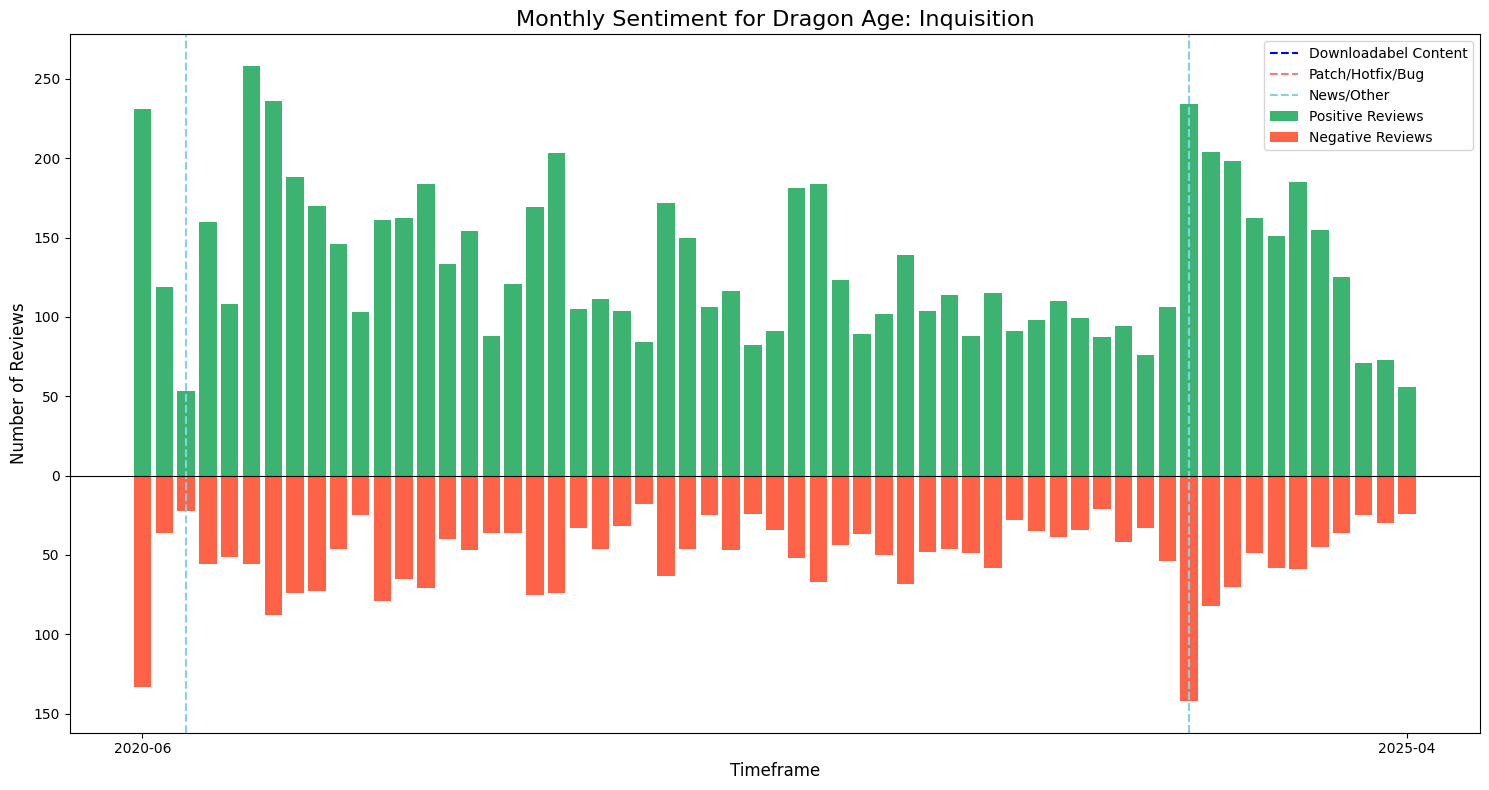

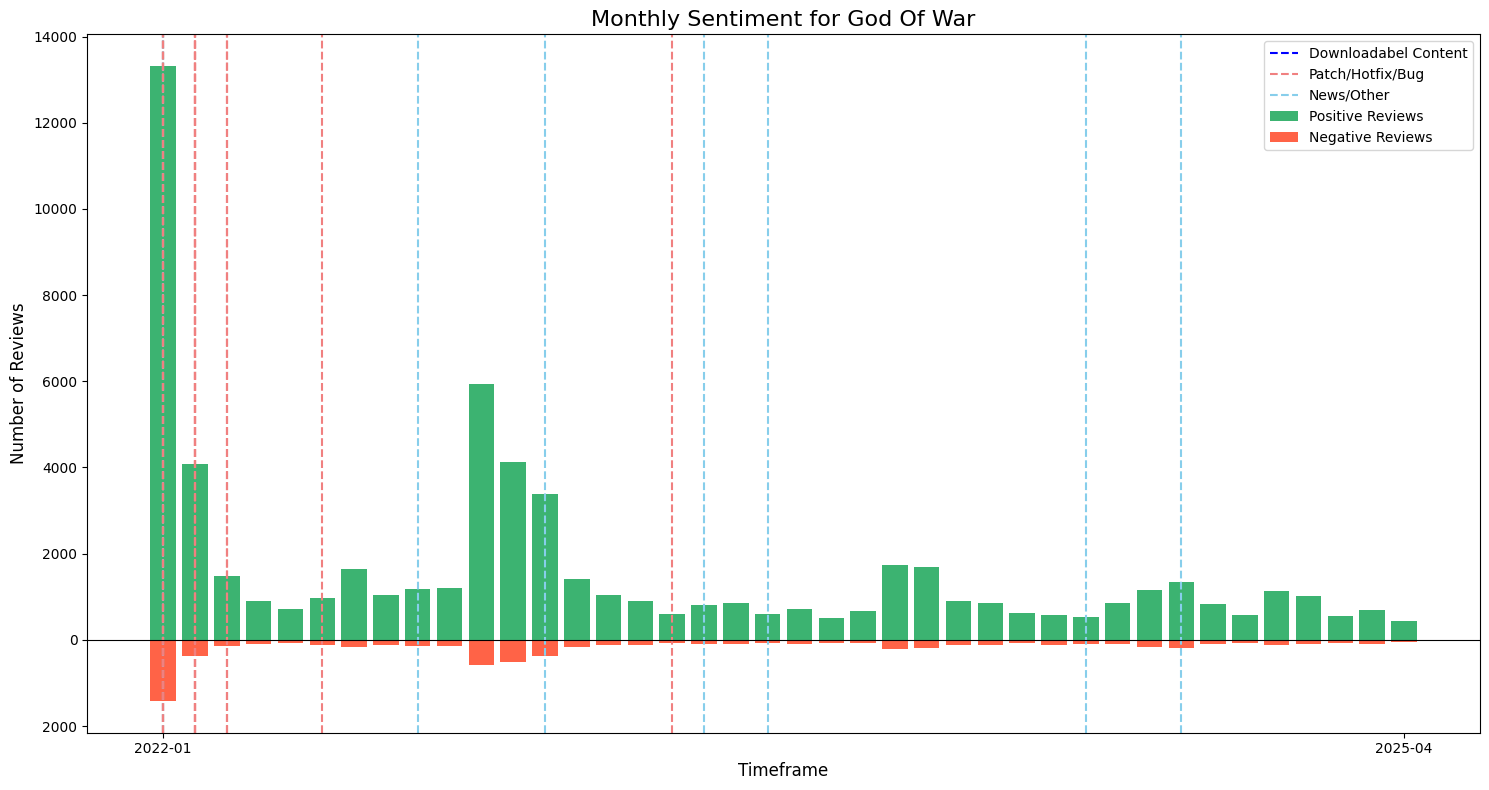

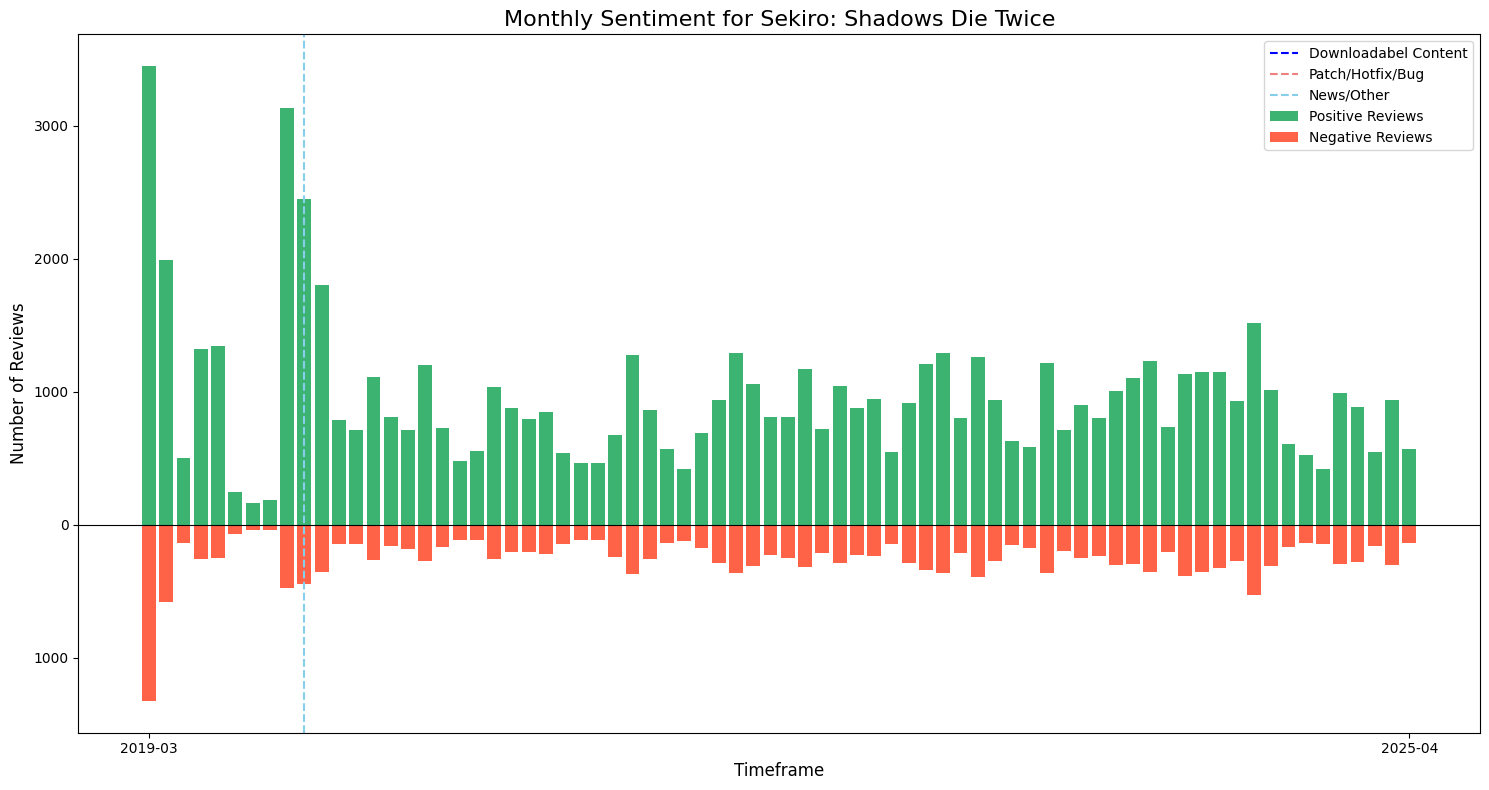

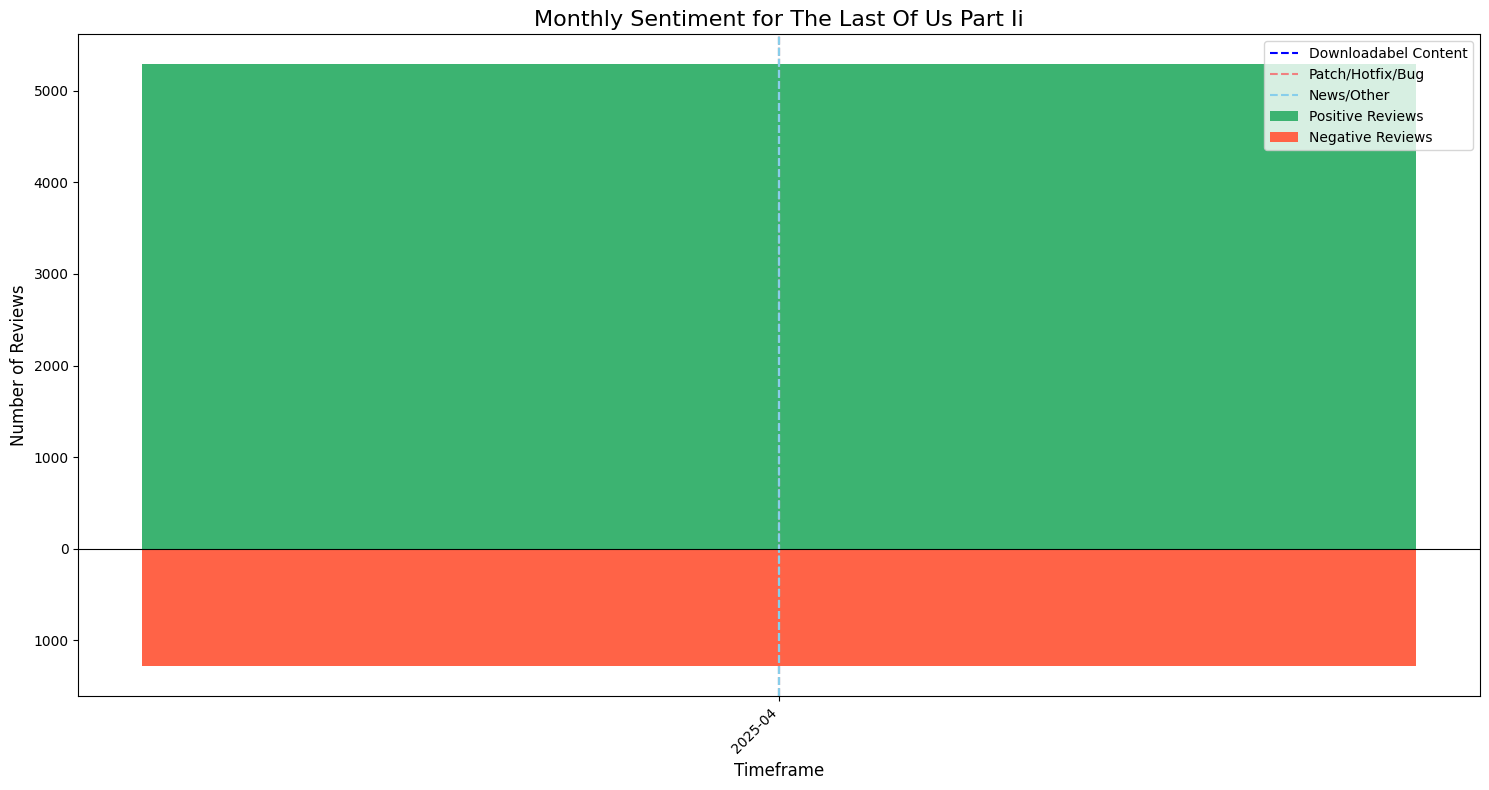

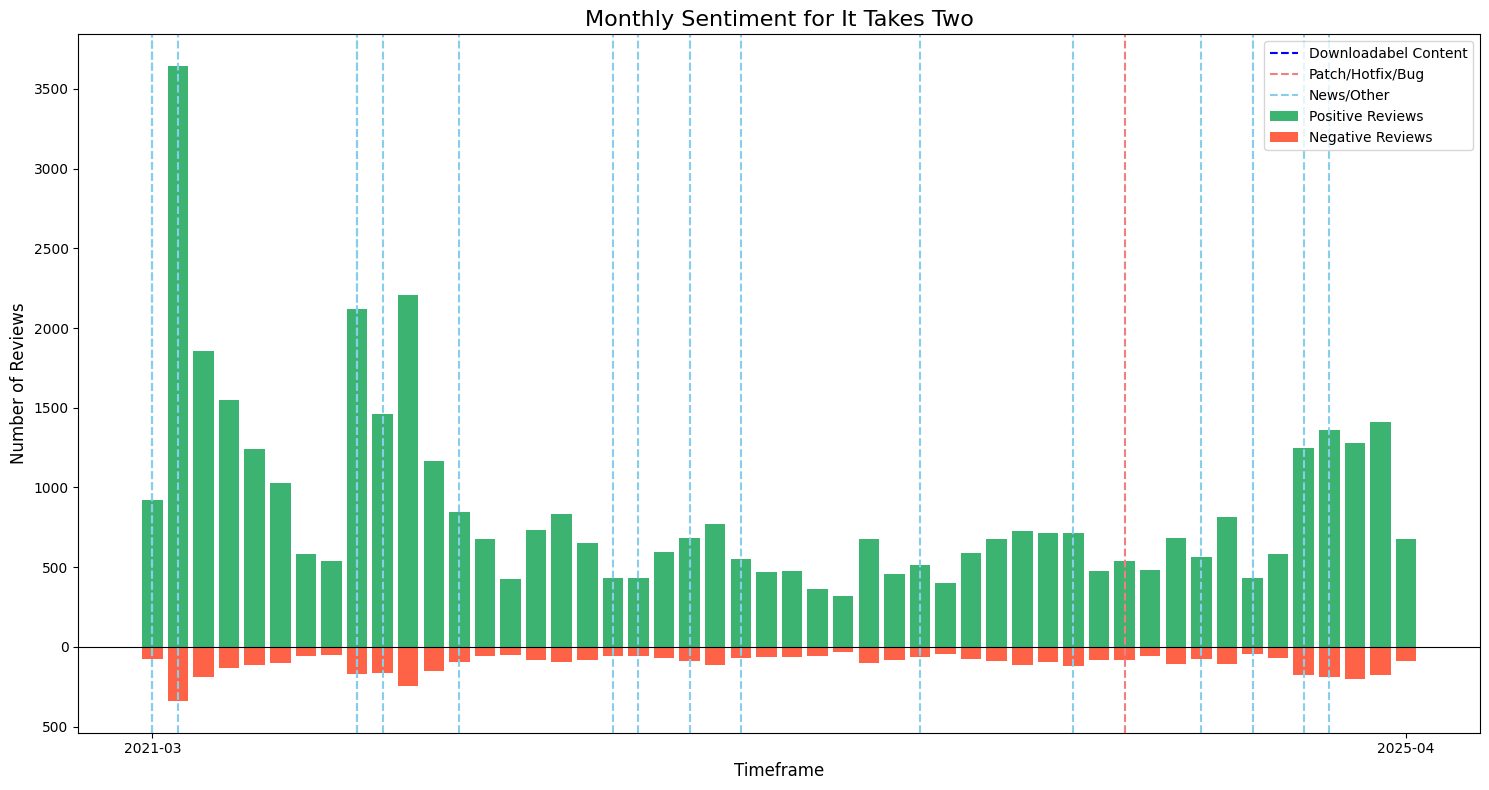

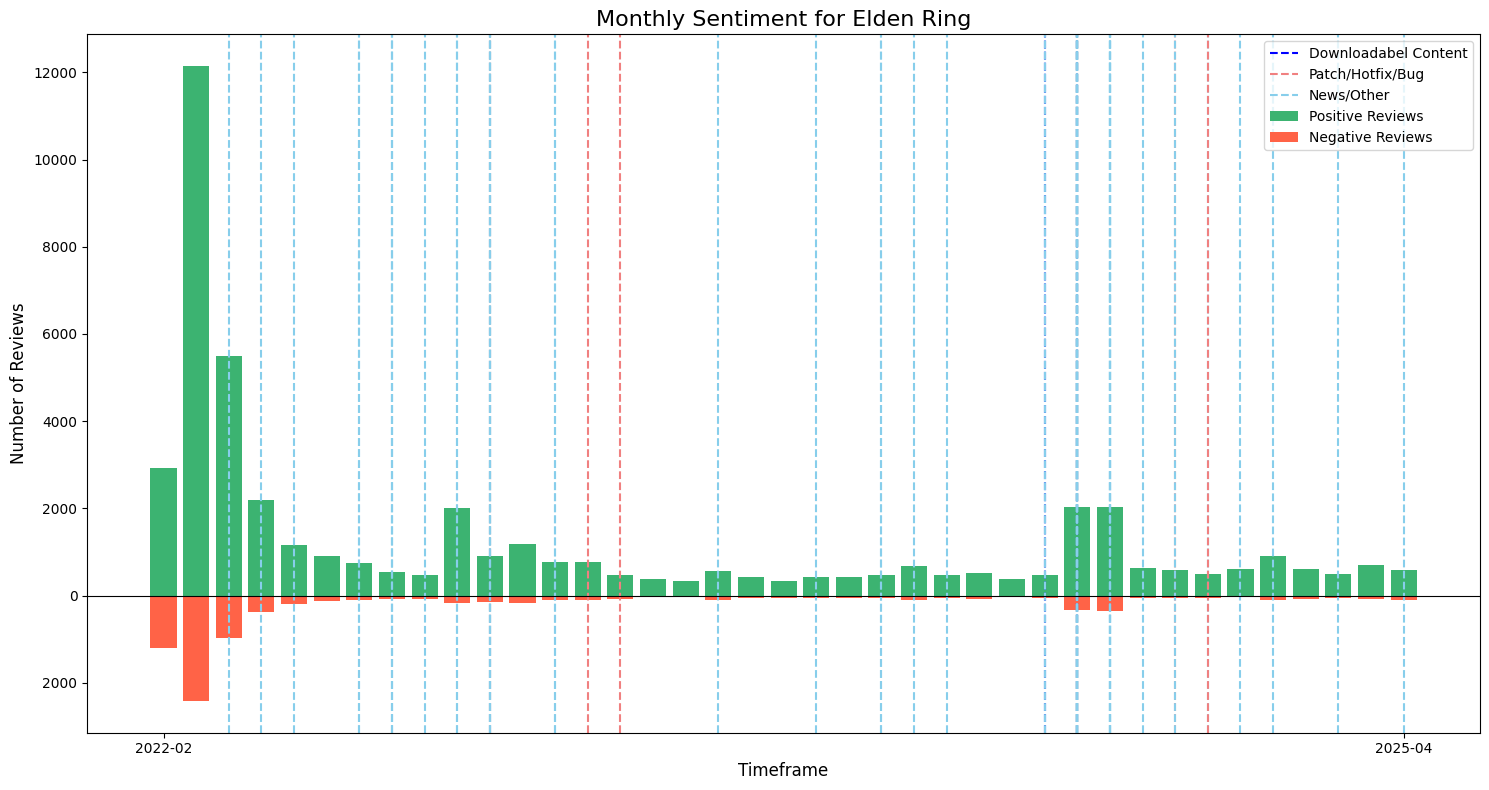

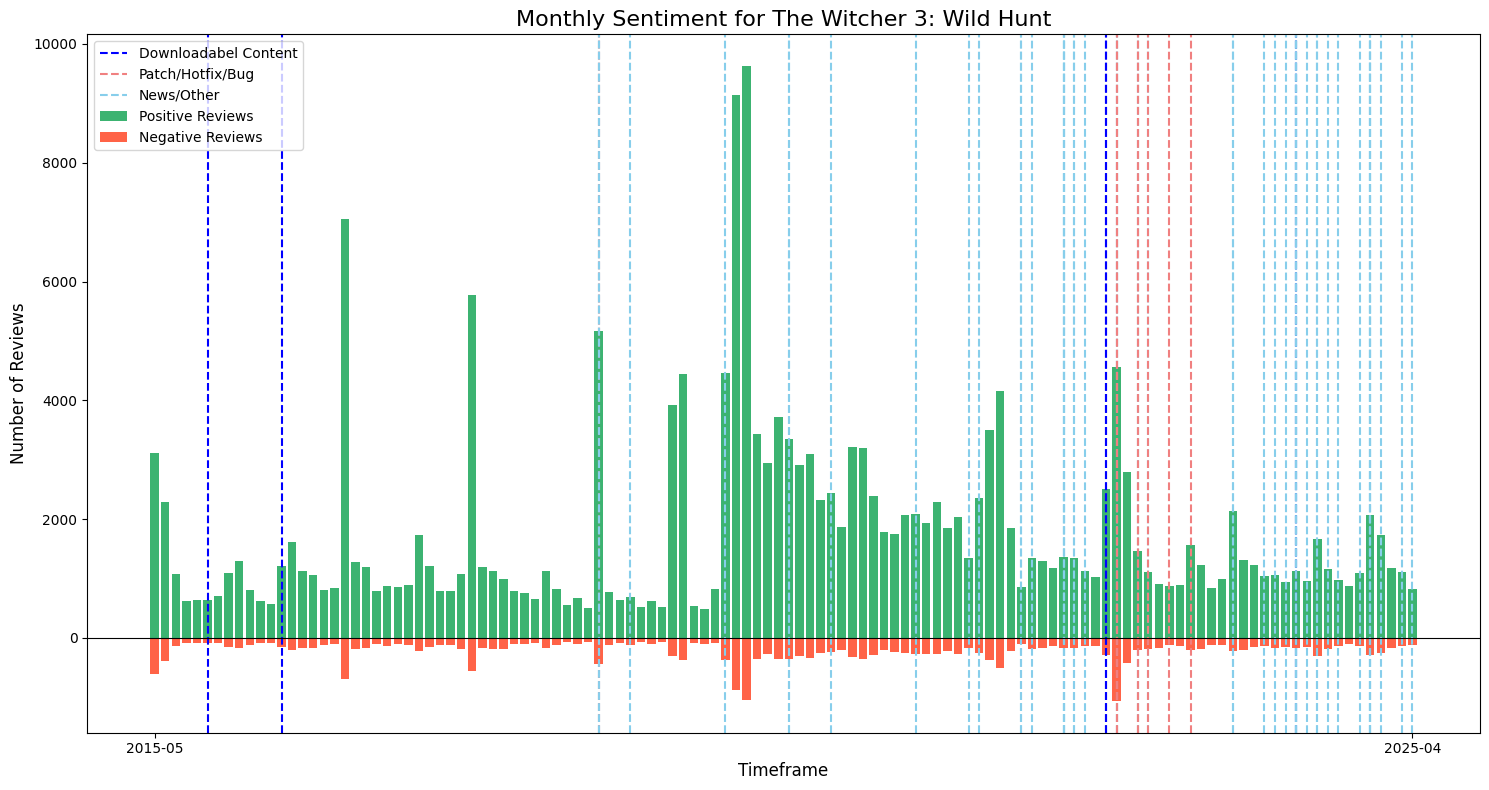

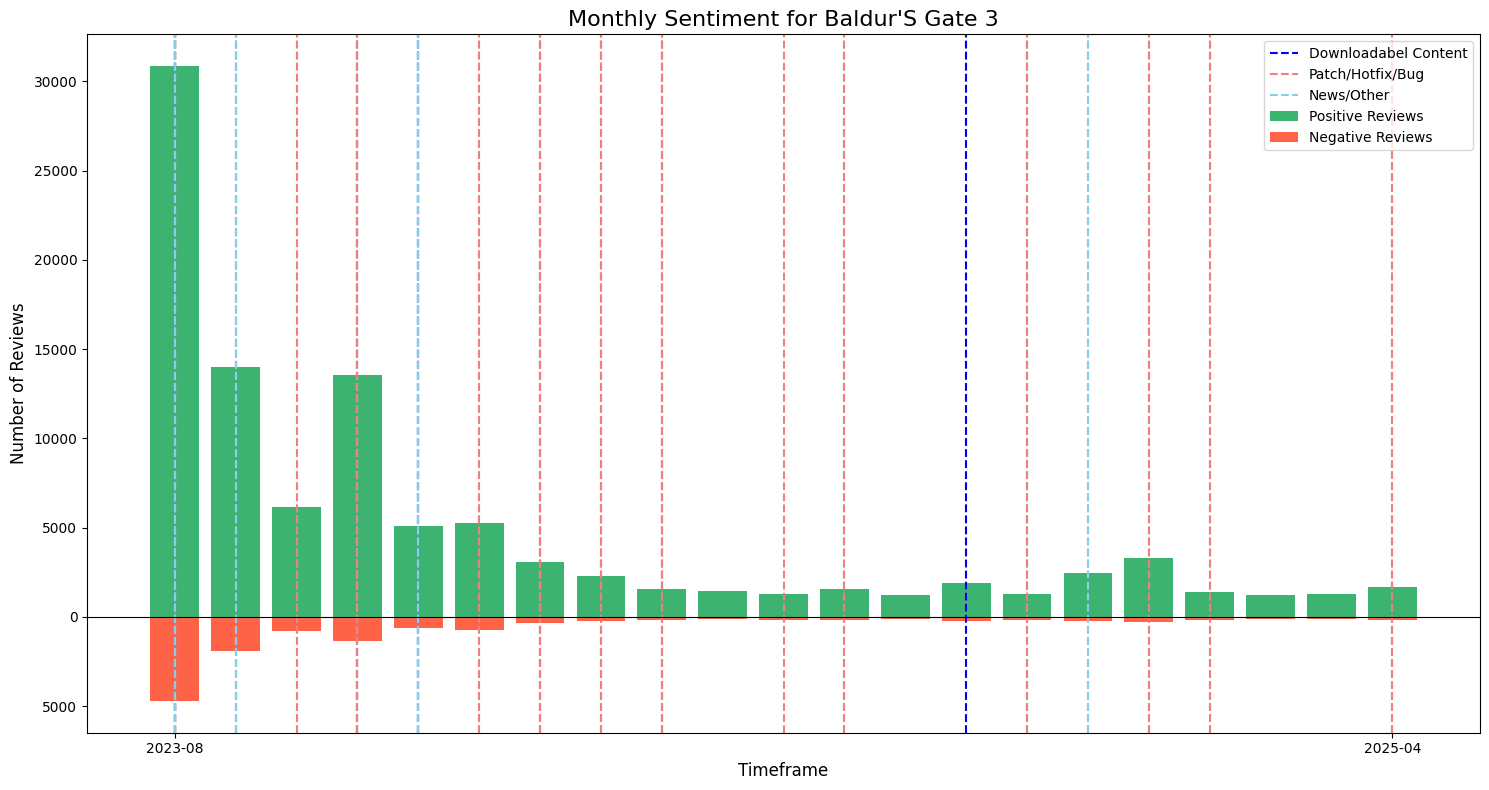

All charts generated successfully.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# --- 1. Load and Prepare Data ---

try:
    reviews_df = pd.read_csv("../output/bert_result.csv")
    reviews_df = reviews_df[~((reviews_df['game'] == "Baldur's Gate 3") & (reviews_df['timestamp_created'] < '2023-08-03'))]
    updates_df = pd.read_csv("../output/steam_update_info.csv")
except FileNotFoundError as e:
    print(f"Error: {e.filename} not found. Please make sure both CSV files are in the correct directory.")
    exit()

# --- 2. Standardize and Prepare Data ---

reviews_df['game'] = reviews_df['game'].str.lower()
updates_df.rename(columns={'game_title': 'game', 'cleaned_date': 'date'}, inplace=True)
updates_df['game'] = updates_df['game'].str.lower()

reviews_df['timestamp_created'] = pd.to_datetime(reviews_df['timestamp_created'])
reviews_df['year_month'] = reviews_df['timestamp_created'].dt.to_period('M')
positive_reviews = reviews_df[reviews_df['sentiment'] == 'Positive'].copy()
negative_reviews = reviews_df[reviews_df['sentiment'] == 'Negative'].copy()

updates_df['date'] = pd.to_datetime(updates_df['date'])
updates_df['topic'] = updates_df['topic'].astype(str)

# --- 3. Differentiate Update Types and Assign Colors ---

dlc_color = 'blue'
patch_color = 'lightcoral'
news_color = 'skyblue'

conditions = [
    updates_df['topic'].str.contains('DLC', case=False),
    updates_df['topic'].str.contains('patch|hotfix|bug', case=False, regex=True)
]
choices = [dlc_color, patch_color]
updates_df['color'] = np.select(conditions, choices, default=news_color)

unique_games = reviews_df['game'].unique()
print(f"Generating {len(unique_games)} plots with cleaned x-axis...")

# --- 4. Generate a Combined Plot for Each Game ---

for game in unique_games:
    positive_counts = positive_reviews[positive_reviews['game'] == game].groupby('year_month').size()
    negative_counts = negative_reviews[negative_reviews['game'] == game].groupby('year_month').size()

    if positive_counts.empty and negative_counts.empty:
        continue

    all_months = sorted(list(set(positive_counts.index) | set(negative_counts.index)))
    positive_counts = positive_counts.reindex(all_months, fill_value=0)
    negative_counts = negative_counts.reindex(all_months, fill_value=0)
    month_labels = [str(month) for month in all_months]

    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.bar(month_labels, positive_counts, color='mediumseagreen', label='Positive Reviews')
    ax.bar(month_labels, -negative_counts, color='tomato', label='Negative Reviews')

    game_updates = updates_df[updates_df['game'] == game]
    if not game_updates.empty:
        ax.plot([], [], color=dlc_color, linestyle='--', label='Downloadable Content')
        ax.plot([], [], color=patch_color, linestyle='--', label='Patch/Hotfix/Bug')
        ax.plot([], [], color=news_color, linestyle='--', label='News/Other')

        for _, row in game_updates.iterrows():
            update_date = row['date']
            update_color = row['color']
            update_month_str = str(update_date.to_period('M'))
            if update_month_str in month_labels:
                x_pos = month_labels.index(update_month_str)
                ax.axvline(x=x_pos, color=update_color, linestyle='--', linewidth=1.5)

    # --- 5. Format the Plot with Cleaned X-Axis ---
    
    ax.set_title(f'Monthly Sentiment for {game.title()}', fontsize=16)
    ax.set_xlabel('Timeframe', fontsize=12)
    ax.set_ylabel('Number of Reviews', fontsize=12)
    ax.axhline(0, color='black', linewidth=0.8)
    
    # **NEW:** Set x-axis ticks to only show the start and end month
    if len(month_labels) > 1:
        ax.set_xticks([0, len(month_labels) - 1])
        ax.set_xticklabels([month_labels[0], month_labels[-1]])
    else:
        # If there's only one month, just show that one
        plt.xticks(rotation=45, ha="right")

    formatter = mticker.FuncFormatter(lambda y, pos: f'{abs(int(y))}')
    ax.yaxis.set_major_formatter(formatter)
    
    ax.legend()
    plt.tight_layout()
    plt.show()

print("All charts generated successfully.")

# Stats

In [14]:
import pandas as pd
import numpy as np

# --- 1. Load and Prepare Data ---

try:
    reviews_df = pd.read_csv("../output/bert_result.csv")
    reviews_df = reviews_df[~((reviews_df['game'] == "Baldur's Gate 3") & (reviews_df['timestamp_created'] < '2023-08-03'))]
    updates_df = pd.read_csv("../output/steam_update_info.csv")
except FileNotFoundError as e:
    print(f"Error: {e.filename} not found. Please make sure both CSV files are in the correct directory.")
    exit()

# --- 2. Standardize and Clean Data ---

# Standardize game names to lowercase
reviews_df['game'] = reviews_df['game'].str.lower()
updates_df.rename(columns={'game_title': 'game', 'cleaned_date': 'date'}, inplace=True)
updates_df['game'] = updates_df['game'].str.lower()

# Prepare sentiment data
reviews_df['timestamp_created'] = pd.to_datetime(reviews_df['timestamp_created'])
reviews_df['year_month'] = reviews_df['timestamp_created'].dt.to_period('M')

# Prepare update data
updates_df['date'] = pd.to_datetime(updates_df['date'])
updates_df['year_month'] = updates_df['date'].dt.to_period('M')
updates_df['topic'] = updates_df['topic'].astype(str) # Ensure topic is string

# --- 3. Aggregate Sentiment and Update Data ---

# Aggregate sentiment counts
sentiment_summary = reviews_df.pivot_table(
    index=['game', 'year_month'],
    columns='sentiment',
    aggfunc='size',
    fill_value=0
)
# Ensure both Positive and Negative columns exist
if 'Positive' not in sentiment_summary.columns:
    sentiment_summary['Positive'] = 0
if 'Negative' not in sentiment_summary.columns:
    sentiment_summary['Negative'] = 0


# Classify update types
conditions = [
    updates_df['topic'].str.contains('DLC', case=False),
    updates_df['topic'].str.contains('patch|hotfix|bug', case=False, regex=True)
]
choices = ['DLC', 'Patch/Fix']
updates_df['update_type'] = np.select(conditions, choices, default='News')

# Aggregate update events
update_summary = updates_df.groupby(['game', 'year_month'])['update_type'].apply(lambda x: ', '.join(sorted(x.unique()))).rename('update_events')


# --- 4. Combine and Finalize Table ---

# Combine sentiment and update summaries
final_table = sentiment_summary.join(update_summary, how='outer')

# Clean up the final table
final_table[['Positive', 'Negative']] = final_table[['Positive', 'Negative']].fillna(0).astype(int)
final_table['update_events'] = final_table['update_events'].fillna('No Events')
final_table.rename(columns={'Positive': 'positive_reviews', 'Negative': 'negative_reviews'}, inplace=True)

# Reset index to make 'game' and 'year_month' regular columns
final_table.reset_index(inplace=True)
final_table['year_month'] = final_table['year_month'].astype(str)

# --- 5. Save to CSV ---

final_table.to_csv('game_sentiment_and_update_summary.csv', index=False)

print("Tabular summary has been generated and saved as 'game_sentiment_and_update_summary.csv'")
final_table

Tabular summary has been generated and saved as 'game_sentiment_and_update_summary.csv'


,game,year_month,negative_reviews,positive_reviews,update_events
0,baldur's gate 3,2023-08,4712,30859,"DLC, News, Patch/Fix"
1,baldur's gate 3,2023-09,1902,13980,"News, Patch/Fix"
2,baldur's gate 3,2023-10,809,6146,"News, Patch/Fix"
3,baldur's gate 3,2023-11,1326,13572,"News, Patch/Fix"
4,baldur's gate 3,2023-12,646,5114,"DLC, News, Patch/Fix"
...,...,...,...,...,...
408,the witcher 3: wild hunt,2025-02,167,1185,No Events
409,the witcher 3: wild hunt,2025-03,142,1111,News
410,the witcher 3: wild hunt,2025-04,119,823,News
411,the witcher 3: wild hunt,2025-05,0,0,News


# Player Classification

Statistik Deskriptif untuk Jam Bermain (playtime_in_hours):
count    636720.000000
mean         86.073760
std         147.510561
min           0.000000
25%          14.730000
50%          44.500000
75%         107.930000
max       21264.200000
Name: playtime_in_hours, dtype: float64


<Axes: >

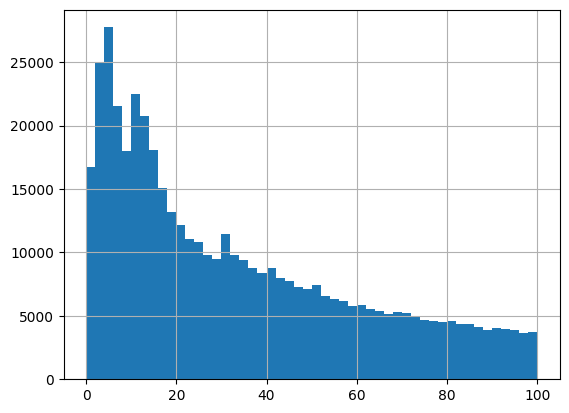

In [29]:
import pandas as pd

# Ganti 'sample.csv' dengan nama file Anda
df = pd.read_csv('reviews_with_author_details.csv')

# Menampilkan statistik utama (mean, median, kuartil)
print("Statistik Deskriptif untuk Jam Bermain (playtime_in_hours):")
print(df['playtime_in_hours'].describe())

# Visualisasikan dengan histogram untuk melihat distribusinya
# Parameter bins bisa disesuaikan untuk melihat detail lebih baik
df['playtime_in_hours'][df['playtime_in_hours'] < 100].hist(bins=50)

In [30]:
import pandas as pd
import ast # Used to safely evaluate the string-formatted dictionary
import numpy as np

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv("../output/bert_result.csv")
    df = df[~((df['game'] == "Baldur's Gate 3") & (df['timestamp_created'] < '2023-08-03'))]
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'bert-result-sample.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- 2. Define Extraction Functions ---

def extract_from_author(author_str, key_to_extract):
    """
    A general function to safely parse the author string and extract a specific key.
    """
    try:
        author_dict = ast.literal_eval(author_str)
        return author_dict.get(key_to_extract, None) # Return None if key doesn't exist
    except (ValueError, SyntaxError):
        # Handles cases where the string is malformed
        return None

# --- 3. Create New Columns ---

print("Extracting new columns from the 'author' string...")

# Create the 'steamid' column
df['steamid'] = df['author'].apply(lambda x: extract_from_author(x, 'steamid'))

# Create 'playtime_at_review' column (in minutes)
df['playtime_at_review_minutes'] = df['author'].apply(lambda x: extract_from_author(x, 'playtime_at_review'))
df['playtime_at_review_minutes'] = pd.to_numeric(df['playtime_at_review_minutes'], errors='coerce').fillna(0)

# Convert playtime to hours and create a new column
df['playtime_in_hours'] = (df['playtime_at_review_minutes'] / 60).round(2)


# --- 4. Classify Players ---

playtime_threshold_hours = 10.0
df['player_category'] = np.where(
    df['playtime_in_hours'] < playtime_threshold_hours,
    'New Player',
    'Experienced Player'
)


# --- 5. Display the Results ---

# Show the first 10 rows with all the new columns to verify the result
print("\n--- Sample of the Transformed Data ---")
print(df[['steamid', 'game', 'playtime_in_hours', 'player_category']].head(10))

# As you requested, you can now group by 'steamid' to see authors with multiple reviews
# print("\n--- Top 5 Authors by Number of Reviews ---")
# print(df['steamid'].value_counts().head(5))

# You can save the final, fully processed DataFrame to a new CSV file
df.to_csv('reviews_with_author_details.csv', index=False)
df['player_category'].value_counts()

Dataset loaded successfully.
Extracting new columns from the 'author' string...

--- Sample of the Transformed Data ---
             steamid                     game  playtime_in_hours  \
0  76561197998282606  Dragon Age: Inquisition              89.65   
1  76561198007277283  Dragon Age: Inquisition             224.87   
2  76561197977249754  Dragon Age: Inquisition               0.23   
3  76561198202036901  Dragon Age: Inquisition              34.47   
4  76561198110956086  Dragon Age: Inquisition               1.20   
5  76561199249619781  Dragon Age: Inquisition               0.15   
6  76561198006595454  Dragon Age: Inquisition               2.73   
7  76561198120560538  Dragon Age: Inquisition              71.47   
8  76561199062620055  Dragon Age: Inquisition              34.82   
9  76561198257102283  Dragon Age: Inquisition               4.93   

      player_category  
0  Experienced Player  
1  Experienced Player  
2          New Player  
3  Experienced Player  
4          

player_category
Experienced Player    527637
New Player            109083
Name: count, dtype: int64

# Player category distribution

In [31]:
import pandas as pd

# Ganti 'sample.csv' dengan nama file Anda
NAMA_FILE_INPUT = 'sample.csv' 

try:
    df = pd.read_csv(NAMA_FILE_INPUT)
    
    print("="*40)
    print("Pemeriksaan Isi Kolom:")
    print("="*40)

    # Cek nilai unik di kolom kategori pemain
    if 'player_category' in df.columns:
        print("\nNilai unik yang ditemukan di kolom 'player_category':")
        print(df['player_category'].unique())
    else:
        print("\nKolom 'player_category' tidak ditemukan.")

    # Cek nilai unik di kolom sentimen
    if 'sentiment' in df.columns:
        print("\nNilai unik yang ditemukan di kolom 'sentiment':")
        print(df['sentiment'].unique())
    else:
        print("\nKolom 'sentiment' tidak ditemukan.")

except FileNotFoundError:
    print(f"Error: File '{NAMA_FILE_INPUT}' tidak ditemukan.")

Pemeriksaan Isi Kolom:

Nilai unik yang ditemukan di kolom 'player_category':
['Experienced Player' 'New Player']

Nilai unik yang ditemukan di kolom 'sentiment':
['Positive' 'Negative']


In [32]:
# 1. Import necessary libraries
import pandas as pd

# --- SETTINGS ---
# Replace 'sample.csv' with the name of your complete dataset file
INPUT_FILENAME = 'reviews_with_author_details.csv' 
OUTPUT_FILENAME = 'sentiment_by_player_type_result.csv'

# 2. Load the complete dataset
try:
    print(f"Reading file: '{INPUT_FILENAME}'...")
    df = pd.read_csv(INPUT_FILENAME)
    print("✅ Dataset loaded successfully.")
    
    # Standardize column names for processing
    # The script assumes your columns are named 'game', 'player_category', and 'sentiment'
    df.rename(columns={'player_category': 'player_type'}, inplace=True)
    
except FileNotFoundError:
    print(f"❌ Error: The file '{INPUT_FILENAME}' was not found.")
    exit()
except KeyError:
    print("❌ Error: Please ensure your CSV file contains the columns 'game', 'player_category', and 'sentiment'.")
    exit()

# 3. Aggregate data and calculate percentages (processing steps are skipped)
print("Calculating sentiment percentages...")
counts = df.groupby(['game', 'player_type', 'sentiment']).size().reset_index(name='count')
total_per_group = df.groupby(['game', 'player_type']).size().reset_index(name='total_reviews')
merged_df = pd.merge(counts, total_per_group, on=['game', 'player_type'])
merged_df['percentage'] = (merged_df['count'] / merged_df['total_reviews']) * 100

# 4. Create the final pivot table
print("Creating the pivot table...")
final_table = merged_df.pivot_table(
    index='game',
    columns=['player_type', 'sentiment'],
    values='percentage',
    fill_value=0
)

# Clean up column names and format the table
final_table.columns = [f'{sentiment} ({player_type})' for player_type, sentiment in final_table.columns]
final_table.index.name = 'Game Title'

# Define the desired column order
desired_order = [
    'Positive (New Player)', 'Negative (New Player)',
    'Positive (Experienced Player)', 'Negative (Experienced Player)'
]
# Ensure we only use columns that exist in the pivoted table
existing_columns_in_order = [col for col in desired_order if col in final_table.columns]
final_table_formatted = final_table[existing_columns_in_order]

# Format numbers into percentage strings
for col in final_table_formatted.columns:
    final_table_formatted[col] = final_table_formatted[col].apply(lambda x: f"{x:.2f}%")

# Display and save the results
print("\n" + "="*60)
print("      FINAL RESULT: SENTIMENT COMPARISON TABLE")
print("="*60)

try:
    final_table_formatted.to_csv(OUTPUT_FILENAME)
    print(f"\n✅ Result table has been saved to: '{OUTPUT_FILENAME}'")
except Exception as e:
    print(f"\n❌ Failed to save the file. Error: {e}")

final_table_formatted

Reading file: 'reviews_with_author_details.csv'...
✅ Dataset loaded successfully.
Calculating sentiment percentages...
Creating the pivot table...

      FINAL RESULT: SENTIMENT COMPARISON TABLE

✅ Result table has been saved to: 'sentiment_by_player_type_result.csv'


,Positive (New Player),Negative (New Player),Positive (Experienced Player),Negative (Experienced Player)
Game Title,,,,
Baldur's Gate 3,81.53%,18.47%,89.28%,10.72%
Dragon Age: Inquisition,56.53%,43.47%,79.51%,20.49%
Elden Ring,66.66%,33.34%,87.56%,12.44%
God of War,87.02%,12.98%,90.83%,9.17%
It Takes Two,85.06%,14.94%,91.59%,8.41%
Sekiro: Shadows Die Twice,68.50%,31.50%,81.42%,18.58%
The Last of Us Part II,79.20%,20.80%,81.31%,18.69%
The Witcher 3: Wild Hunt,84.13%,15.87%,89.83%,10.17%


## Positif

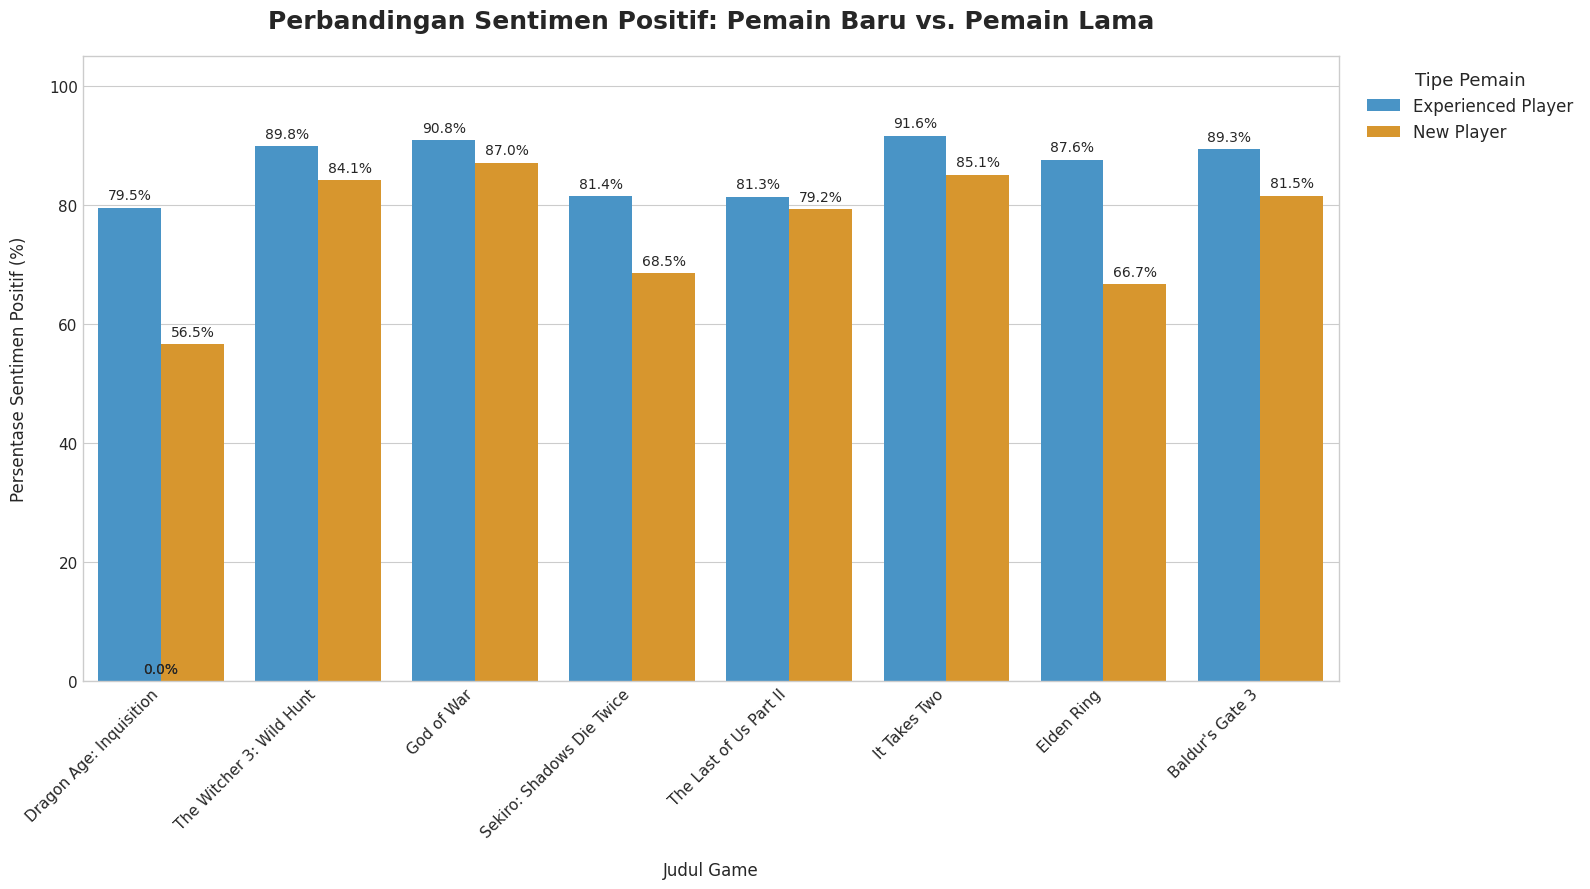


✅ Grafik berhasil disimpan sebagai 'perbandingan_sentimen_diurutkan.png'


<Figure size 640x480 with 0 Axes>

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. MEMUAT DAN MEMPROSES DATA ---
# Ganti 'sample.csv' dengan nama file dataset lengkap Anda
INPUT_FILENAME = 'reviews_with_author_details.csv'

try:
    df = pd.read_csv(INPUT_FILENAME)
    df.rename(columns={'player_category': 'player_type'}, inplace=True)
except Exception as e:
    print(f"Gagal memuat atau memproses file: {e}")
    exit()

positive_df = df[df['sentiment'] == 'Positive'].copy()
positive_counts = positive_df.groupby(['game', 'player_type']).size().reset_index(name='positive_count')
total_per_group = df.groupby(['game', 'player_type']).size().reset_index(name='total_reviews')
merged_df = pd.merge(positive_counts, total_per_group, on=['game', 'player_type'])
merged_df['positive_percentage'] = (merged_df['positive_count'] / merged_df['total_reviews']) * 100

# --- 2. MEMBUAT VISUALISASI DENGAN URUTAN KUSTOM ---

# Tentukan urutan game yang Anda inginkan
game_order = [
    'Dragon Age: Inquisition',
    'The Witcher 3: Wild Hunt',
    'God of War',
    'Sekiro: Shadows Die Twice',
    'The Last of Us Part II',
    'It Takes Two',
    'Elden Ring',
    "Baldur's Gate 3"
]

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

# Buat bar plot dengan menambahkan parameter 'order'
ax = sns.barplot(
    data=merged_df,
    x='game',
    y='positive_percentage',
    hue='player_type',
    order=game_order, # <-- TAMBAHKAN PARAMETER INI UNTUK MENGURUTKAN
    palette=['#3498db', '#f39c12']
)

# --- 3. KUSTOMISASI PLOT ---
plt.title('Perbandingan Sentimen Positif: Pemain Baru vs. Pemain Lama', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Judul Game', fontsize=12, labelpad=15)
plt.ylabel('Persentase Sentimen Positif (%)', fontsize=12, labelpad=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 105)
ax.legend(
    loc='upper left',               
    bbox_to_anchor=(1.01, 1),       
    title='Tipe Pemain',            
    title_fontsize='13',
    fontsize='12'
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10,
        fontweight='medium'
    )

plt.tight_layout()
plt.show()

# Simpan gambar (opsional)
try:
    plt.savefig('perbandingan_sentimen_diurutkan.png', dpi=300)
    print("\n✅ Grafik berhasil disimpan sebagai 'perbandingan_sentimen_diurutkan.png'")
except Exception as e:
    print(f"\n❌ Gagal menyimpan grafik. Error: {e}")

## Negatif

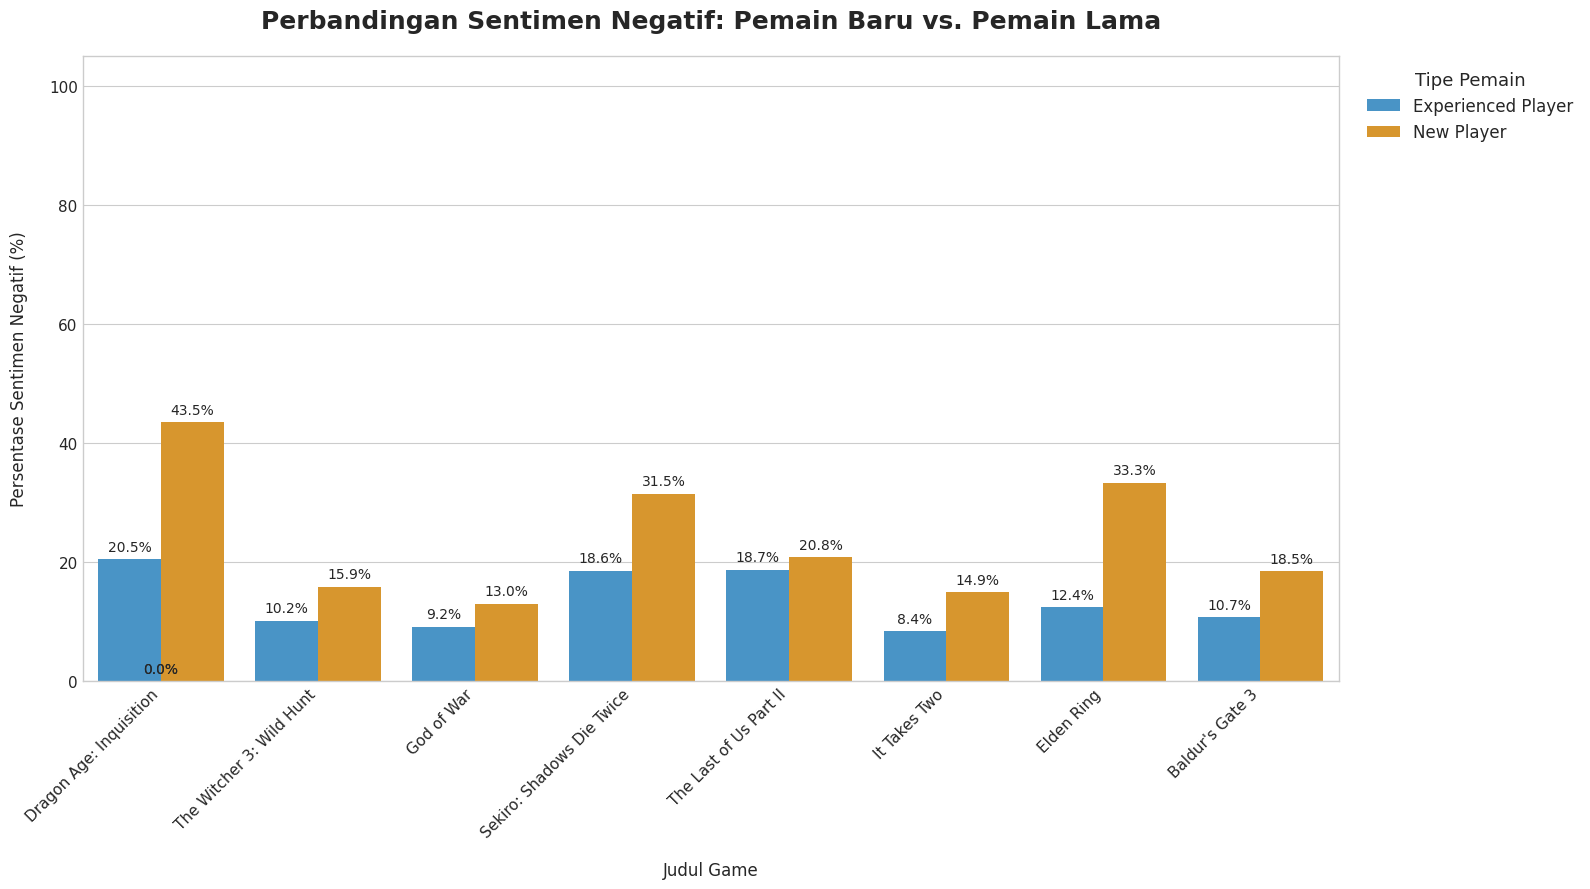


✅ Grafik berhasil disimpan sebagai 'perbandingan_sentimen_diurutkan.png'


<Figure size 640x480 with 0 Axes>

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. MEMUAT DAN MEMPROSES DATA ---
# Ganti 'sample.csv' dengan nama file dataset lengkap Anda
INPUT_FILENAME = 'reviews_with_author_details.csv'

try:
    df = pd.read_csv(INPUT_FILENAME)
    df.rename(columns={'player_category': 'player_type'}, inplace=True)
except Exception as e:
    print(f"Gagal memuat atau memproses file: {e}")
    exit()

negative_df = df[df['sentiment'] == 'Negative'].copy()
negative_counts = negative_df.groupby(['game', 'player_type']).size().reset_index(name='negative_count')
total_per_group = df.groupby(['game', 'player_type']).size().reset_index(name='total_reviews')
merged_df = pd.merge(negative_counts, total_per_group, on=['game', 'player_type'])
merged_df['negative_percentage'] = (merged_df['negative_count'] / merged_df['total_reviews']) * 100

# --- 2. MEMBUAT VISUALISASI DENGAN URUTAN KUSTOM ---

# Tentukan urutan game yang Anda inginkan
game_order = [
    'Dragon Age: Inquisition',
    'The Witcher 3: Wild Hunt',
    'God of War',
    'Sekiro: Shadows Die Twice',
    'The Last of Us Part II',
    'It Takes Two',
    'Elden Ring',
    "Baldur's Gate 3"
]

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

# Buat bar plot dengan menambahkan parameter 'order'
ax = sns.barplot(
    data=merged_df,
    x='game',
    y='negative_percentage',
    hue='player_type',
    order=game_order, # <-- TAMBAHKAN PARAMETER INI UNTUK MENGURUTKAN
    palette=['#3498db', '#f39c12']
)

# --- 3. KUSTOMISASI PLOT ---
plt.title('Perbandingan Sentimen Negatif: Pemain Baru vs. Pemain Lama', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Judul Game', fontsize=12, labelpad=15)
plt.ylabel('Persentase Sentimen Negatif (%)', fontsize=12, labelpad=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 105)
ax.legend(
    loc='upper left',               
    bbox_to_anchor=(1.01, 1),       
    title='Tipe Pemain',            
    title_fontsize='13',
    fontsize='12'
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10,
        fontweight='medium'
    )

plt.tight_layout()
plt.show()

# Simpan gambar (opsional)
try:
    plt.savefig('perbandingan_sentimen_diurutkan_negatif.png', dpi=300)
    print("\n✅ Grafik berhasil disimpan sebagai 'perbandingan_sentimen_diurutkan.png'")
except Exception as e:
    print(f"\n❌ Gagal menyimpan grafik. Error: {e}")

# Oldest and Newest Review

In [40]:
import pandas as pd

# --- 1. Load the Dataset ---
try:
    df = pd.read_csv("../output/bert_result.csv")
    df = df[~((df['game'] == "Baldur's Gate 3") & (df['timestamp_created'] < '2023-08-03'))]
    print("Dataset 'bert-result-sample.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'bert-result-sample.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- 2. Prepare the Data ---
# Ensure the 'timestamp_created' column is in datetime format
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'])

# --- 3. Group and Aggregate Dates ---
print("Calculating the oldest and newest review dates for each game...")

# Group by the 'game' column and apply aggregation to find the min and max dates
date_summary = df.groupby('game')['timestamp_created'].agg(
    oldest_review_date='min',
    newest_review_date='max'
).reset_index() # .reset_index() converts the grouped output back to a DataFrame

# --- 4. Format and Save the New Dataset ---
# Format the date columns to show only the date part (YYYY-MM-DD) for clarity
date_summary['oldest_review_date'] = date_summary['oldest_review_date'].dt.date
date_summary['newest_review_date'] = date_summary['newest_review_date'].dt.date

# Save the resulting DataFrame to a new CSV file
output_filename = 'review_date_info.csv'
date_summary.to_csv(output_filename, index=False)

print(f"\nNew dataset created successfully and saved as '{output_filename}'")

# --- 5. Display the Resulting Table ---
print("\n--- Review Date Summary ---")
date_summary

Dataset 'bert-result-sample.csv' loaded successfully.
Calculating the oldest and newest review dates for each game...

New dataset created successfully and saved as 'review_date_info.csv'

--- Review Date Summary ---


,game,oldest_review_date,newest_review_date
0,Baldur's Gate 3,2023-08-03,2025-04-28
1,Dragon Age: Inquisition,2020-06-04,2025-04-28
2,Elden Ring,2022-02-24,2025-04-28
3,God of War,2022-01-14,2025-04-28
4,It Takes Two,2021-03-26,2025-04-28
5,Sekiro: Shadows Die Twice,2019-03-21,2025-04-28
6,The Last of Us Part II,2025-04-03,2025-04-28
7,The Witcher 3: Wild Hunt,2015-05-18,2025-04-28
